# Assignment 9 – Variance & MSE Plots (Reproduction)
This notebook reproduces the Figure 1–7 style plots from your draft (option B).

In [5]:

# ============================================================
# CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

# Configuration
CSV_PATH   = "https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv"   # synthetic unconventional dataset
RNG_SEED   = 42
N_SPARSE   = 20
TEST_SIZE  = 0.2
N_BOOTSTRAP = 200

# α values to sweep (0.0 => Linear Regression)
ALPHAS_SWEEP = [0.0, 0.1, 1.0, 10.0, 100.0]

# This α is used for direct Linear vs Ridge comparison plots
RIDGE_ALPHA_FOR_COMPARISON = 10.0

# Explicit feature list: match V7 (remove 'Well' if present, add 'VR')
FEATURE_COLS = ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']
TARGET_COL   = 'Prod'


In [6]:

# ============================================================
# BUILD OR REUSE TRAIN/TEST SPLIT
# - Reuses X_train, X_test, y_train, y_test if already defined in the notebook.
# - Otherwise builds a deterministic sparse split from CSV (20 samples total).
# ============================================================
def build_or_reuse_split():
    g = globals()
    if all(k in g for k in ["X_train", "X_test", "y_train", "y_test"]):
        X_train, X_test, y_train, y_test = g["X_train"], g["X_test"], g["y_train"], g["y_test"]
        feature_cols = g.get("FEATURE_COLS", None)
        target_col = g.get("TARGET_COL", None)
        print("Reused existing train/test split from notebook.")
        return X_train, X_test, y_train, y_test, feature_cols, target_col

    # Else: construct from CSV
    df = pd.read_csv(CSV_PATH)
    num_df = df.select_dtypes(include=[np.number]).copy()

    target_col = globals().get("TARGET_COL", None)
    if target_col is None:
        candidates = ["target","y","prod","production","oil_rate","gas_rate","rate",
                      "bhp","pressure","EUR","eur","q","q_oil","q_gas","Prod"]
        target_col = next((c for c in candidates if c in num_df.columns), num_df.columns[-1])

    feature_cols = globals().get("FEATURE_COLS", None)
    if feature_cols is None:
        feature_cols = [c for c in num_df.columns if c != target_col][:6]
        if len(feature_cols) < 2:
            feature_cols = [c for c in num_df.columns if c != target_col]

    X_full = num_df[feature_cols].to_numpy()
    y_full = num_df[target_col].to_numpy()

    rng = np.random.default_rng(RNG_SEED)
    idx = rng.choice(len(X_full), size=min(N_SPARSE, len(X_full)), replace=False)
    X_sparse, y_sparse = X_full[idx], y_full[idx]

    X_train, X_test, y_train, y_test = train_test_split(
        X_sparse, y_sparse, test_size=TEST_SIZE, random_state=RNG_SEED
    )
    print(f"Constructed sparse split | features={feature_cols} | target={target_col} | "
          f"n_sparse={len(X_sparse)} | train={len(X_train)} | test={len(X_test)}")
    return X_train, X_test, y_train, y_test, feature_cols, target_col

X_train, X_test, y_train, y_test, FEATURE_COLS, TARGET_COL = build_or_reuse_split()


Reused existing train/test split from notebook.


In [7]:

# ============================================================
# BOOTSTRAP + FIT/PREDICT
# - Fits Linear (α=0) and Ridge (α>0) inside a Pipeline with scaling.
# - Stores predictions, coefficients, and MSE across bootstraps.
# ============================================================
def fit_predict_bootstrap(Xtr, ytr, Xte, yte, alphas, B, base_seed=12345):
    preds_by_alpha, coefs_by_alpha, mse_by_alpha = {}, {}, {}
    per_point_var = {}
    rows = []

    for a in alphas:
        preds_list, coefs_list, mses = [], [], []

        for b in range(B):
            X_res, y_res = resample(Xtr, ytr, replace=True, random_state=base_seed + b)

            if a == 0.0:
                model = Pipeline([("scaler", StandardScaler()),
                                  ("reg", LinearRegression())])
            else:
                model = Pipeline([("scaler", StandardScaler()),
                                  ("reg", Ridge(alpha=a))])

            model.fit(X_res, y_res)
            y_pred = model.predict(Xte)
            preds_list.append(y_pred)

            reg = model.named_steps["reg"]
            coefs_list.append(np.ravel(reg.coef_))
            mses.append(mean_squared_error(yte, y_pred))

        preds = np.vstack(preds_list)   # (B, n_test)
        coefs = np.vstack(coefs_list)   # (B, n_features)
        mses = np.asarray(mses)

        pointwise_var = preds.var(axis=0)
        mean_pred_var = float(pointwise_var.mean())
        mean_coef_var = float(coefs.var(axis=0).mean())

        preds_by_alpha[a] = preds
        coefs_by_alpha[a] = coefs
        mse_by_alpha[a]   = mses
        per_point_var[a]  = pointwise_var

        rows.append({
            "alpha": a,
            "mean_pred_variance": mean_pred_var,
            "mean_coef_variance": mean_coef_var,
            "mse_mean": float(mses.mean()),
            "mse_std":  float(mses.std())
        })

    return pd.DataFrame(rows), preds_by_alpha, coefs_by_alpha, mse_by_alpha, per_point_var

results_df, preds_by_alpha, coefs_by_alpha, mse_by_alpha, per_point_var = fit_predict_bootstrap(
    X_train, y_train, X_test, y_test, ALPHAS_SWEEP, N_BOOTSTRAP
)

print("=== FEATURES/TARGET INFO ===")
print(f"FEATURE_COLS: {FEATURE_COLS}")
print(f"TARGET_COL:   {TARGET_COL}\n")

print("=== PER-ALPHA SUMMARY ===")
print(results_df.to_string(index=False))


=== FEATURES/TARGET INFO ===
FEATURE_COLS: ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']
TARGET_COL:   Prod

=== PER-ALPHA SUMMARY ===
 alpha  mean_pred_variance  mean_coef_variance      mse_mean       mse_std
   0.0       150562.703279        31886.828912 204622.743602 757355.951455
   0.1        72030.388314        12717.657923 112914.160191 136194.873925
   1.0        56019.282836         5493.176199 100313.802707 122127.573701
  10.0        43417.141061         3044.173262 268083.972501 163024.569694
 100.0        38066.677256          478.915976 998668.252514 274217.981482


In [5]:

# ============================================================
# VARIANCE RATIOS VS LINEAR
# - Compares prediction variance at each test point: Var(α) / Var(Linear)
# - Ratio < 1 indicates variance reduction relative to Linear.
# ============================================================
def percentile_ci(arr, lo=2.5, hi=97.5):
    return (np.percentile(arr, lo), np.percentile(arr, hi))

linear_var_pp = per_point_var[0.0]  # per-point prediction variance for Linear

variance_ratios = {}
for a in ALPHAS_SWEEP:
    if a == 0.0:
        continue
    ratio_vec = per_point_var[a] / np.maximum(linear_var_pp, 1e-12)
    variance_ratios[a] = {
        "mean_ratio": float(ratio_vec.mean()),
        "ci_95": percentile_ci(ratio_vec)
    }

print("\n=== VARIANCE RATIOS (Prediction variance: Ridge / Linear) ===")
for a in ALPHAS_SWEEP:
    if a == 0.0:
        continue
    lo, hi = variance_ratios[a]["ci_95"]
    print(f"alpha={a:>5}: mean_ratio={variance_ratios[a]['mean_ratio']:.3f} | 95% CI [{lo:.3f}, {hi:.3f}]")



=== VARIANCE RATIOS (Prediction variance: Ridge / Linear) ===
alpha=  0.1: mean_ratio=0.596 | 95% CI [0.308, 0.879]
alpha=  1.0: mean_ratio=0.450 | 95% CI [0.219, 0.694]
alpha= 10.0: mean_ratio=0.381 | 95% CI [0.127, 0.553]
alpha=100.0: mean_ratio=0.467 | 95% CI [0.133, 1.146]


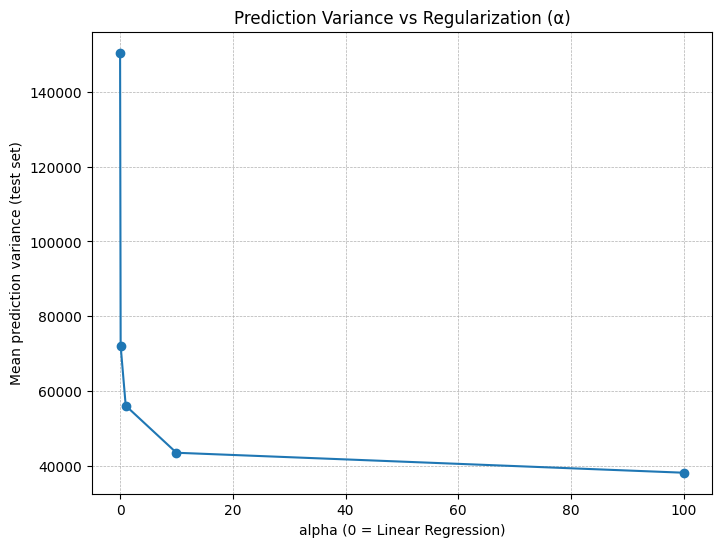

In [9]:
# Figure Title: Line (Figure 1)

# PLOT 1: Prediction variance vs α (α-sweep)
# FIGURE TITLE: Prediction Variance vs Regularization (α)
# PURPOSE: Demonstrates the core outcome—variance decreases with stronger regularization.

plt.figure(figsize=(8,6))
plt.plot(results_df["alpha"], results_df["mean_pred_variance"], marker='o')
plt.xlabel("alpha (0 = Linear Regression)")
plt.ylabel("Mean prediction variance (test set)")
plt.title("Prediction Variance vs Regularization (α)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


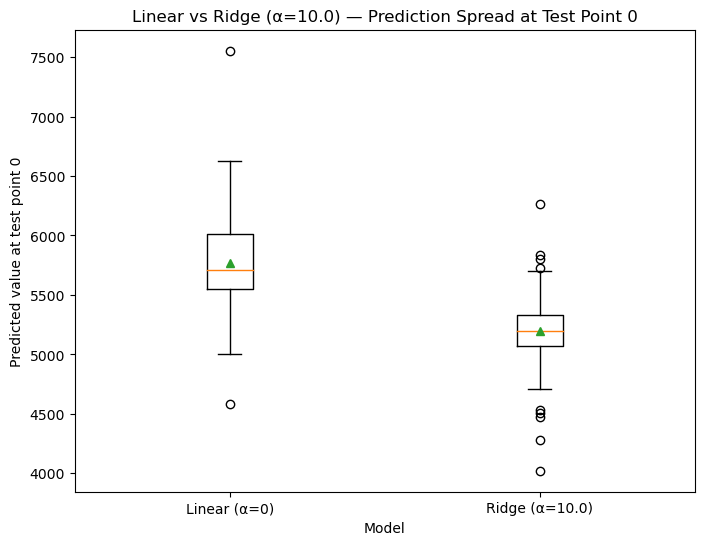

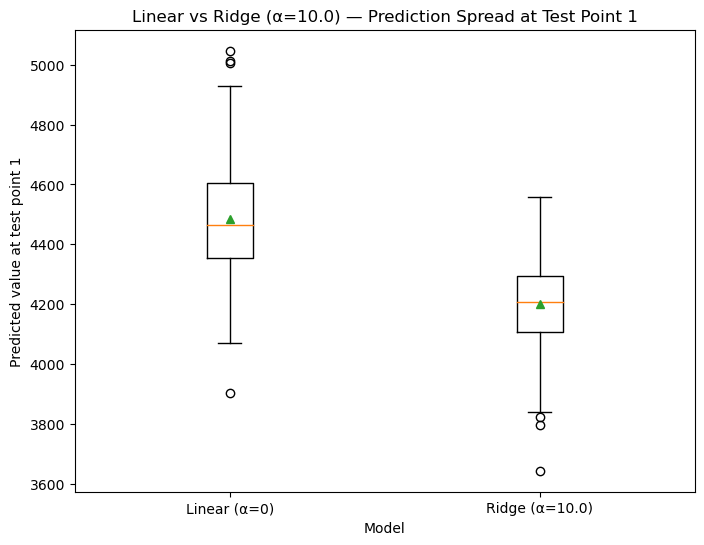

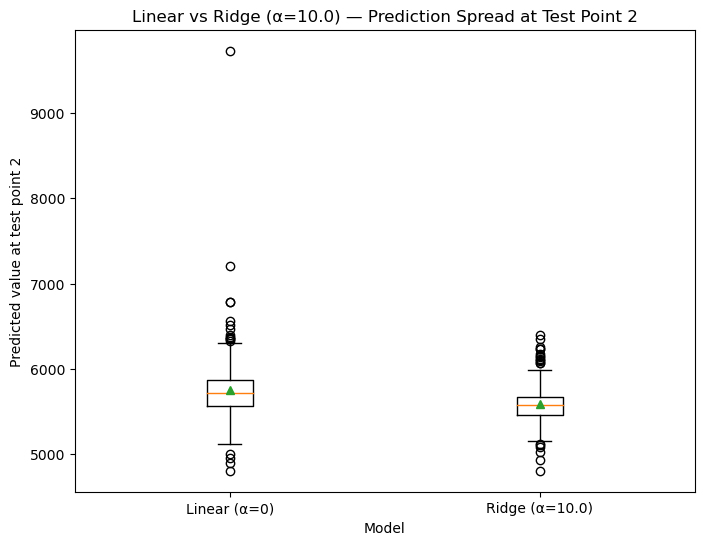

In [7]:
# Figure Title: Plot (Figure 2)

# PLOT 2: Linear vs Ridge (α=10) — per-test-point prediction spread (boxplots)
# FIGURE TITLE: Linear vs Ridge (α = 10): Prediction Spread at Selected Test Points
# PURPOSE: Visualize how bootstrapped predictions shrink under ridge regularization at specific test samples.

RIDGE_ALPHA_FOR_COMPARISON = 10.0  # ensure consistent with config

if len(y_test) >= 3:
    fixed_idx = [0, 1, 2]
else:
    fixed_idx = list(range(len(y_test)))

for j in fixed_idx:
    plt.figure(figsize=(8,6))
    data = [
        preds_by_alpha[0.0][:, j],                           # Linear
        preds_by_alpha[RIDGE_ALPHA_FOR_COMPARISON][:, j]     # Ridge(α=10)
    ]
    plt.boxplot(data, labels=["Linear (α=0)", f"Ridge (α={RIDGE_ALPHA_FOR_COMPARISON})"], showmeans=True)
    plt.xlabel("Model")
    plt.ylabel(f"Predicted value at test point {j}")
    plt.title(f"Linear vs Ridge (α={RIDGE_ALPHA_FOR_COMPARISON}) — Prediction Spread at Test Point {j}")
    plt.show()


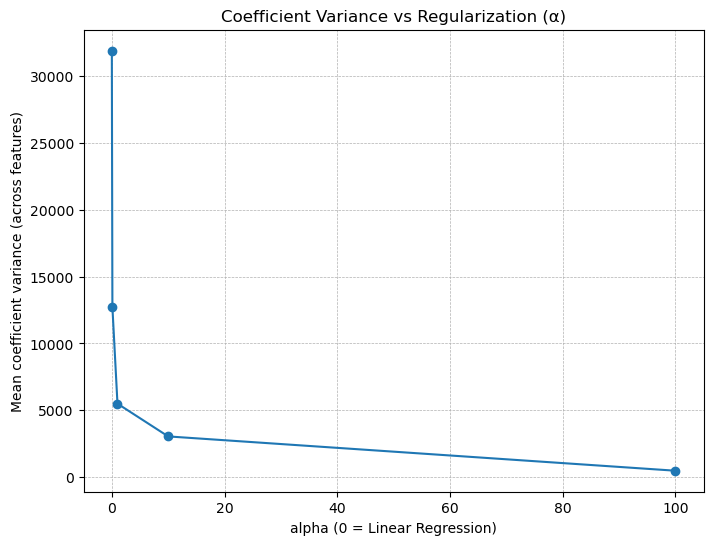

In [8]:
# Figure Title: Line (Figure 3)

# PLOT 3: Coefficient variance vs α (α-sweep)
# FIGURE TITLE: Coefficient Variance vs Regularization (α)
# PURPOSE: Shows parameter (coefficient) stabilization under ridge, explaining reduced predictive variance.

plt.figure(figsize=(8,6))
plt.plot(results_df["alpha"], results_df["mean_coef_variance"], marker='o')
plt.xlabel("alpha (0 = Linear Regression)")
plt.ylabel("Mean coefficient variance (across features)")
plt.title("Coefficient Variance vs Regularization (α)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()


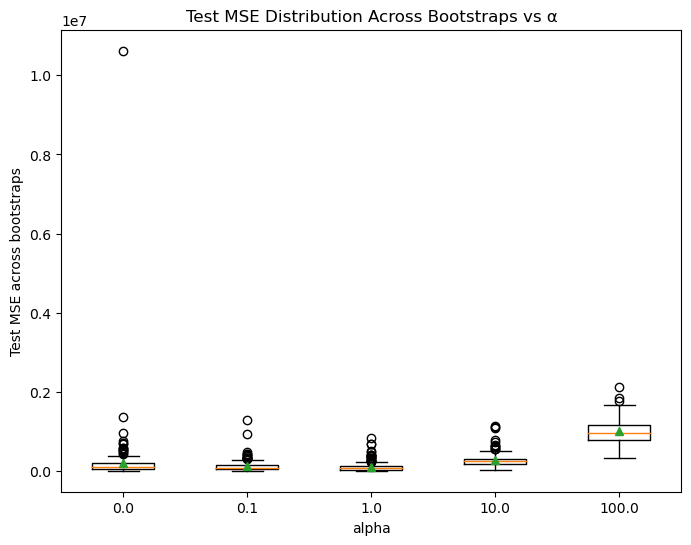

In [9]:
# Figure Title: Plot (Figure 4)

# PLOT 4: MSE distribution across bootstraps for each α (α-sweep)
# FIGURE TITLE: Test MSE Distribution Across Bootstraps vs α
# PURPOSE: Illustrates bias–variance trade-off; MSE spread typically narrows with regularization.

plt.figure(figsize=(8,6))
plt.boxplot([mse_by_alpha[a] for a in ALPHAS_SWEEP],
            labels=[str(a) for a in ALPHAS_SWEEP], showmeans=True)
plt.xlabel("alpha")
plt.ylabel("Test MSE across bootstraps")
plt.title("Test MSE Distribution Across Bootstraps vs α")
plt.show()


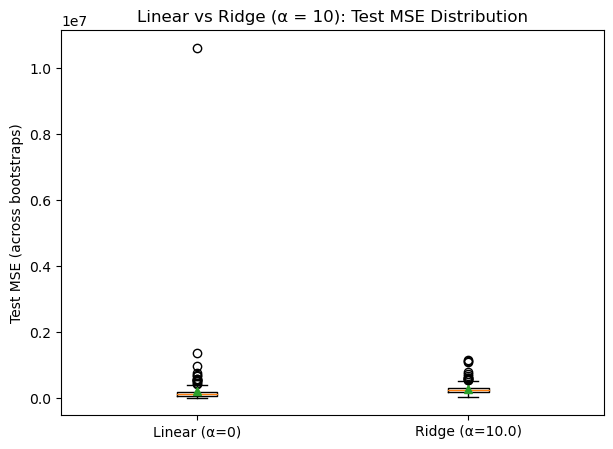

In [10]:
# Figure Title: Plot (Figure 5)

# PLOT 5: Linear vs Ridge (α=10) — Test MSE distribution (side-by-side boxplots for clarity)
# FIGURE TITLE: Linear vs Ridge (α = 10): Test MSE Distribution
# PURPOSE: Complementary comparison of overall error spread; consider ECDF if preferred.

mse_lin   = mse_by_alpha[0.0]
mse_ridge = mse_by_alpha[RIDGE_ALPHA_FOR_COMPARISON]

plt.figure(figsize=(7,5))
plt.boxplot([mse_lin, mse_ridge],
            labels=["Linear (α=0)", f"Ridge (α={RIDGE_ALPHA_FOR_COMPARISON})"],
            showmeans=True)
plt.ylabel("Test MSE (across bootstraps)")
plt.title("Linear vs Ridge (α = 10): Test MSE Distribution")
plt.show()


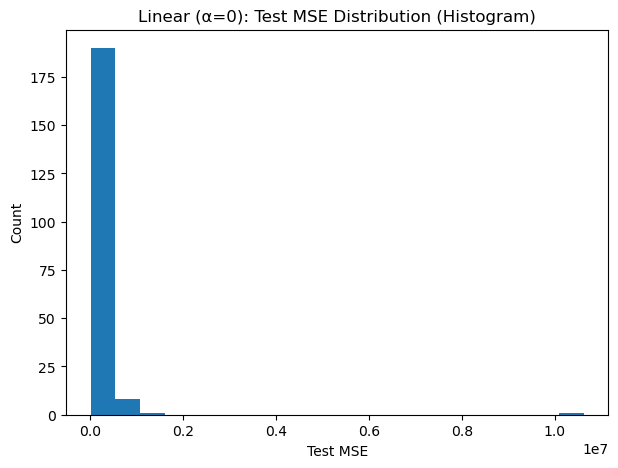

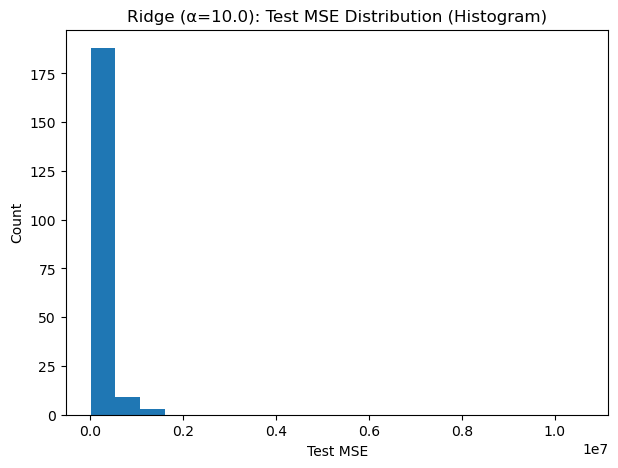

In [11]:
# Figure Title: Hist (Figure 6)

# PLOT 6: Linear vs Ridge (α=10) — Test MSE Distribution (Histogram)
# FIGURE TITLE: Linear vs Ridge (α = 10): Test MSE Distribution (Histogram)
# PURPOSE: Frequency-based comparison of error distributions; complements boxplots.
# NOTE: Uses shared binning/range for fair visual comparison.

mse_lin   = mse_by_alpha[0.0]
mse_ridge = mse_by_alpha[RIDGE_ALPHA_FOR_COMPARISON]

combined = np.concatenate([mse_lin, mse_ridge])
bins = max(10, int(np.sqrt(len(combined))))
range_min, range_max = float(np.min(combined)), float(np.max(combined))

plt.figure(figsize=(7,5))
plt.hist(mse_lin, bins=bins, range=(range_min, range_max))
plt.xlabel("Test MSE")
plt.ylabel("Count")
plt.title("Linear (α=0): Test MSE Distribution (Histogram)")
plt.show()

plt.figure(figsize=(7,5))
plt.hist(mse_ridge, bins=bins, range=(range_min, range_max))
plt.xlabel("Test MSE")
plt.ylabel("Count")
plt.title(f"Ridge (α={RIDGE_ALPHA_FOR_COMPARISON}): Test MSE Distribution (Histogram)")
plt.show()


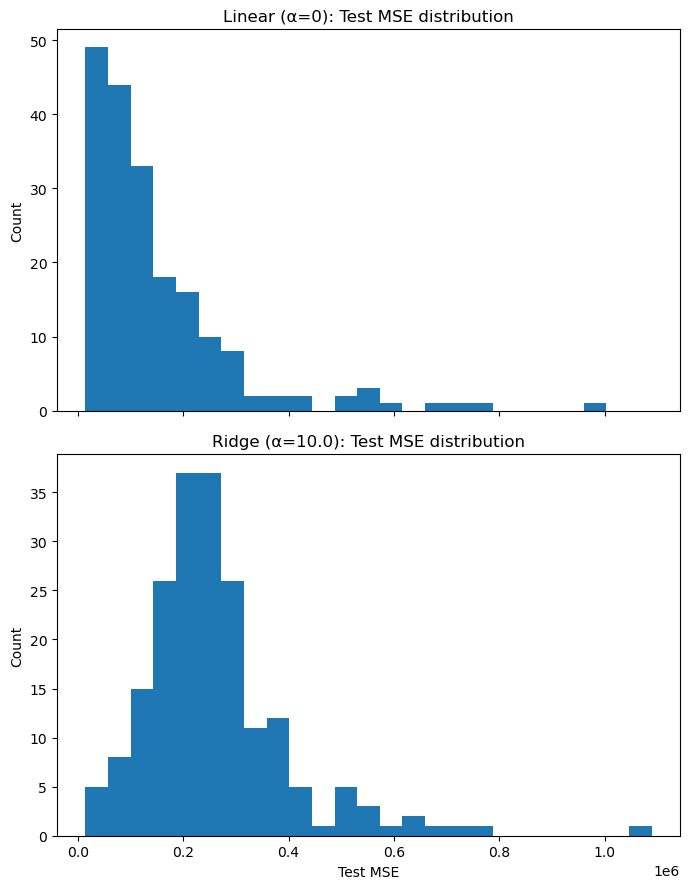

In [12]:
# Figure Title: Subplots (Figure 7)
# Suggested: plt.title('Subplots (Figure 7)')
# Improved histogram (same logic as 9B)
import numpy as np
import matplotlib.pyplot as plt

mse_lin   = mse_by_alpha[0.0]
mse_ridge = mse_by_alpha[RIDGE_ALPHA_FOR_COMPARISON]

# Use 1st–99th percentile for more realistic range
low, high = np.percentile(np.concatenate([mse_lin, mse_ridge]), [1, 99])
bins = 25

fig, axes = plt.subplots(2, 1, figsize=(7, 9), sharex=True)
axes[0].hist(mse_lin, bins=bins, range=(low, high))
axes[0].set_title("Linear (α=0): Test MSE distribution")
axes[0].set_ylabel("Count")

axes[1].hist(mse_ridge, bins=bins, range=(low, high))
axes[1].set_title(f"Ridge (α={RIDGE_ALPHA_FOR_COMPARISON}): Test MSE distribution")
axes[1].set_xlabel("Test MSE")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [8]:
# Quick comparison: run bootstrap for two feature sets (V7 vs Option B)
import pandas as pd

df = pd.read_csv(CSV_PATH)

def run_for_features(feat_list, seed=RNG_SEED):
    num_df = df.select_dtypes(include=[np.number]).copy()
    target_col = TARGET_COL
    X_full = num_df[feat_list].to_numpy()
    y_full = num_df[target_col].to_numpy()
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X_full), size=min(N_SPARSE, len(X_full)), replace=False)
    X_sparse, y_sparse = X_full[idx], y_full[idx]
    Xtr, Xte, ytr, yte = train_test_split(X_sparse, y_sparse, test_size=TEST_SIZE, random_state=seed)
    res_df, preds, coefs, mses, per_point = fit_predict_bootstrap(Xtr, ytr, Xte, yte, ALPHAS_SWEEP, N_BOOTSTRAP)
    print("Features:", feat_list)
    print(res_df.to_string(index=False))
    return res_df, preds, coefs, mses, per_point

v7_feats = ["Por","Brittle","Perm","TOC","AI","VR"]
ob_feats = FEATURE_COLS  # as detected earlier in this notebook

res_v7, preds_v7, coefs_v7, mses_v7, pp_v7 = run_for_features(v7_feats)
res_ob, preds_ob, coefs_ob, mses_ob, pp_ob = run_for_features(ob_feats)

comp = pd.DataFrame({
    'alpha': res_v7['alpha'],
    'mean_pred_var_v7': res_v7['mean_pred_variance'],
    'mean_pred_var_ob': res_ob['mean_pred_variance']
})
print('\nComparison:')
print(comp.to_string(index=False)
)


Features: ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']
 alpha  mean_pred_variance  mean_coef_variance     mse_mean      mse_std
   0.0       338867.754816        63215.485848 4.040173e+05 3.388599e+06
   0.1        73673.248843        12168.576912 1.099024e+05 1.612535e+05
   1.0        47909.201446         4787.164970 8.921426e+04 9.717605e+04
  10.0        33047.896012         2583.146484 2.802778e+05 1.549412e+05
 100.0        35857.318958          429.376562 1.033170e+06 2.724039e+05
Features: ['Por', 'Brittle', 'Perm', 'TOC', 'AI', 'VR']
 alpha  mean_pred_variance  mean_coef_variance     mse_mean      mse_std
   0.0       338867.754816        63215.485848 4.040173e+05 3.388599e+06
   0.1        73673.248843        12168.576912 1.099024e+05 1.612535e+05
   1.0        47909.201446         4787.164970 8.921426e+04 9.717605e+04
  10.0        33047.896012         2583.146484 2.802778e+05 1.549412e+05
 100.0        35857.318958          429.376562 1.033170e+06 2.724039e+05

Comparison: